## Generate dataset


In [1]:
import numpy as np


def gen_dataset(n_samples, seq_len, vocab_size):
    X = np.random.randint(1, vocab_size, size=(n_samples, seq_len))
    Y = np.flip(X, axis=1)

    return X, Y

In [2]:
# Hyperparameters
vocab_size = 99
d_model = 128
seq_len = 10
num_heads = 4

In [3]:
X, Y = gen_dataset(
    n_samples=20000,
    seq_len=seq_len,
    vocab_size=vocab_size
)

train_end = int(0.8 * len(X))
val_end = int(0.9 * len(X))

# (n_samples, seq_len)
X_train, Y_train = X[:train_end], Y[:train_end]
X_val, Y_val = X[train_end: val_end], Y[train_end:val_end]
X_test, Y_test = X[val_end:], Y[val_end:]

## Embedding layer


In [4]:
import torch
import torch.nn as nn
import math

# Initialised randomly from N(0, 1)
# (vocab_size, d_model)
embedding = nn.Embedding(vocab_size, d_model)

# "Attention Is All You Need" S3.4: "In the embedding layers, we multiply those weights by √dmodel"
# (n_samples, seq_len, d_model)
emb = embedding(torch.from_numpy(X_train)) * math.sqrt(d_model)

### Positional Encoding


In [53]:
# (seq_len, d_model)
def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)

    # (1, d_model // 2)
    # i has to represent the columns in the final matrix, therefore unsqueeze 0
    i = torch.arange(0, d_model // 2).unsqueeze(0)

    # (seq_len, 1)
    pos = torch.arange(0, seq_len).unsqueeze(1)

    # (seq_len, d_model // 2)
    term = pos / torch.pow(10000, 2 * i / d_model)

    pe[:, 0::2] = torch.sin(term)
    pe[:, 1::2] = torch.cos(term)

    return pe


pe = get_positional_encoding(seq_len, d_model)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super().__init__()

        pe = torch.zeros(seq_len, d_model)

        # (1, d_model // 2)
        # i has to represent the columns in the final matrix, therefore unsqueeze 0
        i = torch.arange(0, d_model // 2).unsqueeze(0)

        # (seq_len, 1)
        pos = torch.arange(0, seq_len).unsqueeze(1)

        # (seq_len, d_model // 2)
        term = pos / torch.pow(10000, 2 * i / d_model)

        pe[:, 0::2] = torch.sin(term)
        pe[:, 1::2] = torch.cos(term)

        pe = pe.unsqueeze(0)

        # Move to gpu for the below x + self.pe operation
        self.register_buffer('pe', pe)

    def forward(self, x):
        # n_samples, seq_len, d_model
        return x + self.pe

### Sum


In [55]:
# (n_samples, seq_len, d_model)
x = emb + pe

## Multihead Attention


In [84]:
import torch.nn.functional as F


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h):
        super().__init__()
        assert d_model % h == 0, "d_model must be divisible by num_heads"

        self.h = h
        self.d_k = d_model // h

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)

    def forward(self, x):
        n_samples, seq_len, d_model = x.size()

        # (n_samples, seq_len, d_model)
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # (n_samples, seq_len, h, d_k)
        Q = Q.view(n_samples, seq_len, self.h, self.d_k)
        K = K.view(n_samples, seq_len, self.h, self.d_k)
        V = V.view(n_samples, seq_len, self.h, self.d_k)

        # Swap h and seq_len, matmul only works on last 2 dimensions
        # (n_samples, h, seq_len, d_k)
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        qkt = Q @ K.transpose(2, 3)  # (n_samples, h, seq_len, seq_len)
        scaled = qkt / math.sqrt(self.d_k)
        weights = F.softmax(scaled, dim=-1)

        self.attn_weights = weights

        output = weights @ V  # (n_samples, h, seq_len, d_k)

        # (n_samples, seq_len, d_model)
        concat = output.transpose(1, 2).contiguous().view(
            n_samples, seq_len, d_model)

        return self.W_O(concat)

In [85]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, h)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        mha_out = self.mha(x)
        x = self.norm1(x + mha_out)

        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        # (batch, seq_len, dims)
        return x

In [86]:
class TransformerReverser(nn.Module):
    def __init__(self, vocab_size, d_model, seq_len, num_heads, num_layers):
        super().__init__()

        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(seq_len, d_model)
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, num_heads * 4) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = self.pos_encoding(x)

        for layer in self.layers:
            x = layer(x)

        x = self.fc_out(x)
        return x

In [87]:
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = TransformerReverser(
    vocab_size=vocab_size,
    d_model=d_model,
    seq_len=seq_len,
    num_heads=num_heads,
    num_layers=4
)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [88]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0

    for inputs, targets in dataloader:
        # inputs = (batch, seqlen)
        # targets = (batch, seqlen)
        inputs, targets = inputs.to(device), targets.to(device)

        # (batch_size, seq len, vocabsize)
        logits = model(inputs)

        # CrossEntropyLoss expects (batch, num_classes)
        loss = criterion(logits.view(-1, vocab_size), targets.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval(dataloader, model, criterion):
    model.eval()
    total_loss = 0

    # to calculate accuracy
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            # inputs = (batch, seqlen)
            # targets = (batch, seqlen)
            inputs, targets = inputs.to(device), targets.to(device)

            # (batch_size, seq len, vocabsize)
            logits = model(inputs)

            # CrossEntropyLoss expects (batch, num_classes)
            loss = criterion(logits.view(-1, vocab_size), targets.view(-1))

            # (batch_size, seqlen)
            predictions = torch.argmax(logits, dim=-1)
            total_loss += loss.item()
            correct += (predictions == targets).sum().item()
            total += targets.numel()

    return total_loss / len(dataloader), (correct / total) * 100

In [89]:
from torch.utils.data import DataLoader, Dataset


class ReversalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X.copy()).long()
        self.Y = torch.tensor(Y.copy()).long()

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)


train_dataset = ReversalDataset(X_train, Y_train)
val_dataset = ReversalDataset(X_val, Y_val)
test_dataset = ReversalDataset(X_test, Y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_loss, val_acc = eval(train_loader, model, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 01 | Train Loss: 0.9375 | Val Loss: 0.0096 | Val Acc: 99.85%
Epoch 02 | Train Loss: 0.0162 | Val Loss: 0.0015 | Val Acc: 100.00%
Epoch 03 | Train Loss: 0.0008 | Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 04 | Train Loss: 0.0004 | Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 05 | Train Loss: 0.0003 | Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 06 | Train Loss: 0.0002 | Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 07 | Train Loss: 0.0001 | Val Loss: 0.0001 | Val Acc: 100.00%


KeyboardInterrupt: 

In [106]:
def reverse_this(sequence, model, device):
    model.eval()
    with torch.no_grad():
        # 1. Prepare input
        x = torch.tensor([sequence]).long().to(device)

        # 2. Get prediction
        logits = model(x)
        preds = torch.argmax(logits, dim=-1)

        # 3. Convert back to list
        return preds.cpu().numpy()[0].tolist()


# Try a sequence
my_test = [0, 12, 14, 16, 18, 20, 22, 24, 26, 28]
result = reverse_this(my_test, model, device)

print(f"Input:    {my_test}")
print(f"Reversed: {result}")

Input:    [0, 12, 14, 16, 18, 20, 22, 24, 26, 28]
Reversed: [26, 26, 24, 22, 20, 18, 16, 14, 12, 12]


In [100]:
# 1. Create a placeholder to store the weights
saved_attention = {}


def hook_fn(m, i, o):
    # This grabs the weights from the softmax in your MultiHeadAttention
    # We'll need to slightly tweak your MHA to make this variable accessible,
    # or just use this trick to grab the output of the softmax specifically.
    saved_attention['weights'] = o


# 2. Attach the hook to the attention layer of the first block
# Assuming your EncoderBlock has an attribute 'mha'
handle = model.layers[0].mha.register_forward_hook(hook_fn)

# 3. Run the inference again
test_seq = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 5]]).to(device)
model(test_seq)

# 4. Remove the hook so it doesn't slow down the model later
handle.remove()

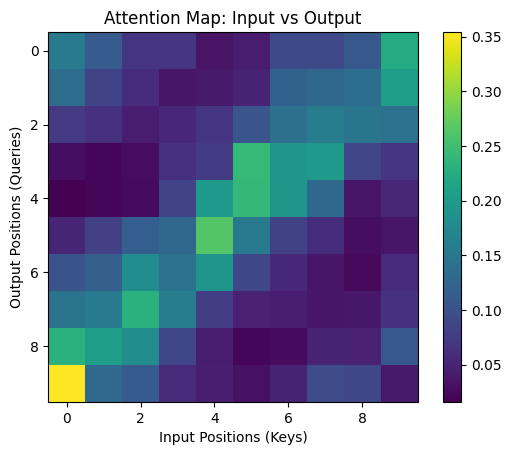

In [102]:
# 1. Run a sample
test_seq = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]]).to(device)
model(test_seq)

# 2. Access the weights from the first layer's mha module
# Shape will be (1, num_heads, seq_len, seq_len)
weights = model.layers[0].mha.attn_weights

# 3. Average across heads and remove batch dim -> (seq_len, seq_len)
attn_map = weights[0].mean(dim=0).cpu().detach().numpy()

# 4. Plot
plt.imshow(attn_map, cmap='viridis')
plt.title("Attention Map: Input vs Output")
plt.xlabel("Input Positions (Keys)")
plt.ylabel("Output Positions (Queries)")
plt.colorbar()
plt.show()